
# PACKAGES IMPORT AND ENVIRONMENT SETUP



In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
#np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import initializers
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns

# IMPORT IMAGES FROM DIRECTORY
 Each folder contains 2 folders: one "healthy" for healthy images and one "unhealthy" for unhealthy images


In [ ]:
TRAIN_DIR="/kaggle/input/notebook18fcc195e4/data/training_folder"
VAL_DIR="/kaggle/input/notebook18fcc195e4/data/validation_folder"
TEST_DIR="/kaggle/input/notebook18fcc195e4/data/test_folder"
IMG_SHAPE=(96,96)
BATCH_SIZE=32

In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:

train_ds_one = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96, 96),
    shuffle=True,
    seed=seed
)


train_ds_two =tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96, 96),
    shuffle=True,
    seed=seed+3
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds =tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96, 96),
    shuffle=False,
    seed=seed
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96, 96),
    shuffle=True,
    seed=seed
)

Found 3928 files belonging to 2 classes.
Found 3928 files belonging to 2 classes.
Found 437 files belonging to 2 classes.
Found 485 files belonging to 2 classes.


In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1 )
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.1):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

In [ ]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)


[0.8807215094566345, 0.11927849054336548]
[0.01947993040084839, 0.9805200695991516]
[0.17810429632663727, 0.8218957185745239]
[1.0, 0.0]
[1.0, 0.0]
[0.00018602609634399414, 0.999813973903656]
[1.0, 0.0]
[0.47806316614151, 0.52193683385849]
[1.0, 0.0]


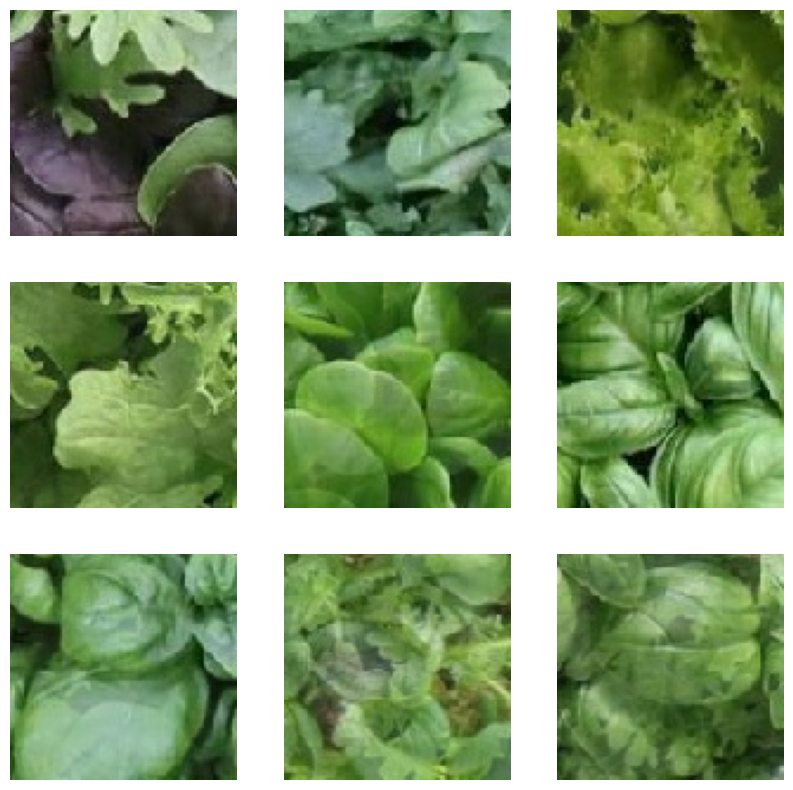

In [ ]:
# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze()/255)
    print(label.numpy().tolist())
    plt.axis("off")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train generator with augmentation
train_image_gen  = ImageDataGenerator()

train_dataset = train_image_gen.flow_from_directory(directory=TRAIN_DIR,
                                                    target_size=IMG_SHAPE,
                                                   # color_mode='rgb',
                                                    classes=None,
                                                    class_mode='binary',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=seed,
                                                    )

test_dataset = train_image_gen.flow_from_directory(directory=TEST_DIR,
                                                    target_size=IMG_SHAPE,
                                                   # color_mode='rgb',
                                                    classes=None,
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=seed,
                                                    )

Found 3928 images belonging to 2 classes.
Found 485 images belonging to 2 classes.


In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_dataset.classes),
                                                  y=train_dataset.classes)

class_weights = dict(zip(np.unique(train_dataset.classes), class_weights))
class_weights

{0: 0.7925746569814366, 1: 1.3544827586206896}

## **Training VGG19 w/ regularization**

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input

VGG19 = tfk.applications.VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)
VGG19.trainable = True

In [ ]:
regularizer = tfk.regularizers.l2(0.001)

In [ ]:
regularizer = tfk.regularizers.l2(0.001)

for layer in VGG19.layers:
    if isinstance(layer, tfkl.Conv2D):
        layer.kernel_regularizer = regularizer

In [ ]:
scheduler = tfk.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,  # Initial learning rate for training
    decay_steps=10000,            # Number of steps before decaying the learning rate
    decay_rate=0.9,              # Rate at which the learning rate decreases
)

lr_callback = tfk.callbacks.LearningRateScheduler(scheduler)

In [ ]:
preprocessing = tf.keras.Sequential([
       # tfkl.RandomBrightness(0.2,value_range=(0,1)),
          tfkl.RandomFlip("horizontal"),
        tfkl.RandomFlip("vertical"),
       # tfkl.RandomContrast(0.3),
        tfkl.RandomRotation(0.5),
       # tfkl.RandomTranslation(0.2,0.2,fill_mode="reflect"),
        #tfkl.RandomZoom(0.5,0.5,fill_mode="reflect")
    ], name='preprocessing')


inputs = tfk.Input(shape=(96, 96, 3))

preprocess=preprocessing(inputs)
x = preprocess_input(preprocess)

x = VGG19(x)
# Add a Dense layer with 2 units and softmax activation as the classifier


x=tfkl.Flatten()(x)
x=tfkl.Dense(128, activation='relu' ,kernel_initializer=tfk.initializers.GlorotNormal())(x)

x=tfkl.Dropout(0.4)(x)


outputs = tfkl.Dense(2, activation='softmax' ,kernel_initializer=tfk.initializers.GlorotNormal() )(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='VGG19')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 tf.__operators__.getitem_1  (None, 96, 96, 3)         0         
 1 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_11 (TFOpLam  (None, 96, 96, 3)         0         
 bda)                                                            
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_11 (Flatten)        (None, 4608)              0     

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_ds_mu,
    batch_size = 32,
    epochs = 200,
    validation_data = val_ds,
    class_weight=class_weights,
   callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True), lr_callback]
                # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy' ,factor=20**-4 ,patience=5)]
).history

Epoch 1/200
123/123 [==============================] - 26s 129ms/step - loss: 1.0442 - accuracy: 0.5252 - val_loss: 0.6505 - val_accuracy: 0.6041 - lr: 1.0000e-05
Epoch 2/200
123/123 [==============================] - 15s 118ms/step - loss: 0.6920 - accuracy: 0.5741 - val_loss: 0.5700 - val_accuracy: 0.6796 - lr: 9.9999e-06
Epoch 3/200
123/123 [==============================] - 15s 119ms/step - loss: 0.6369 - accuracy: 0.6390 - val_loss: 0.5627 - val_accuracy: 0.6911 - lr: 9.9998e-06
Epoch 4/200
123/123 [==============================] - 15s 117ms/step - loss: 0.5839 - accuracy: 0.6940 - val_loss: 0.4944 - val_accuracy: 0.7689 - lr: 9.9997e-06
Epoch 5/200
123/123 [==============================] - 15s 117ms/step - loss: 0.5626 - accuracy: 0.7301 - val_loss: 0.5221 - val_accuracy: 0.7300 - lr: 9.9996e-06
Epoch 6/200
123/123 [==============================] - 15s 117ms/step - loss: 0.5468 - accuracy: 0.7454 - val_loss: 0.4570 - val_accuracy: 0.7849 - lr: 9.9995e-06
Epoch 7/200
123/123 [=

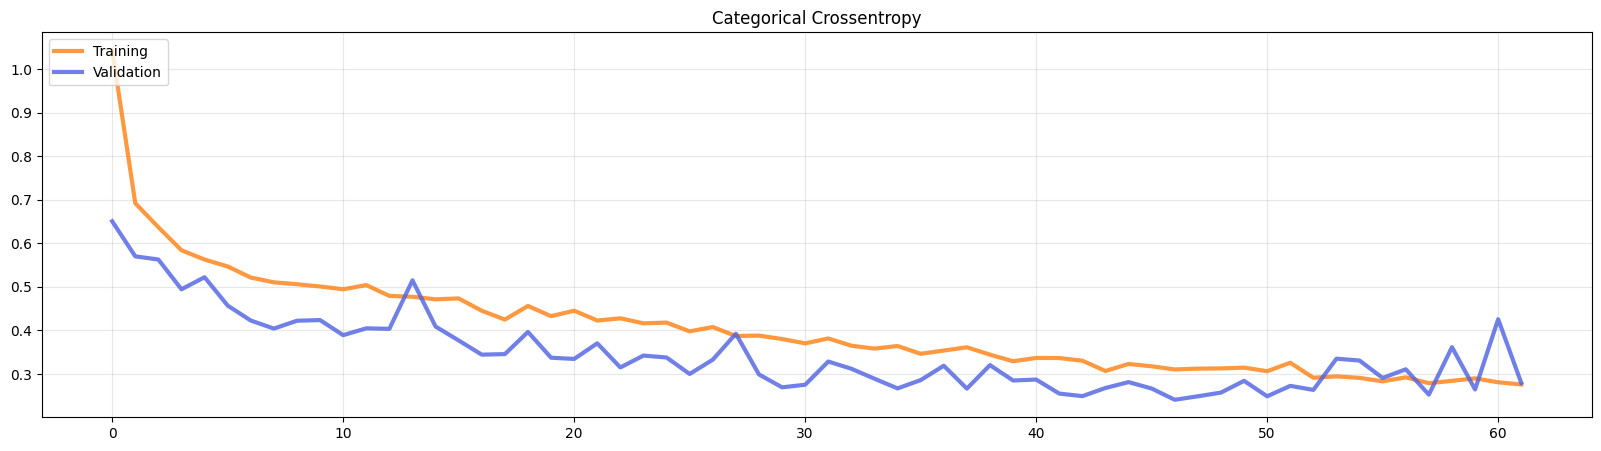

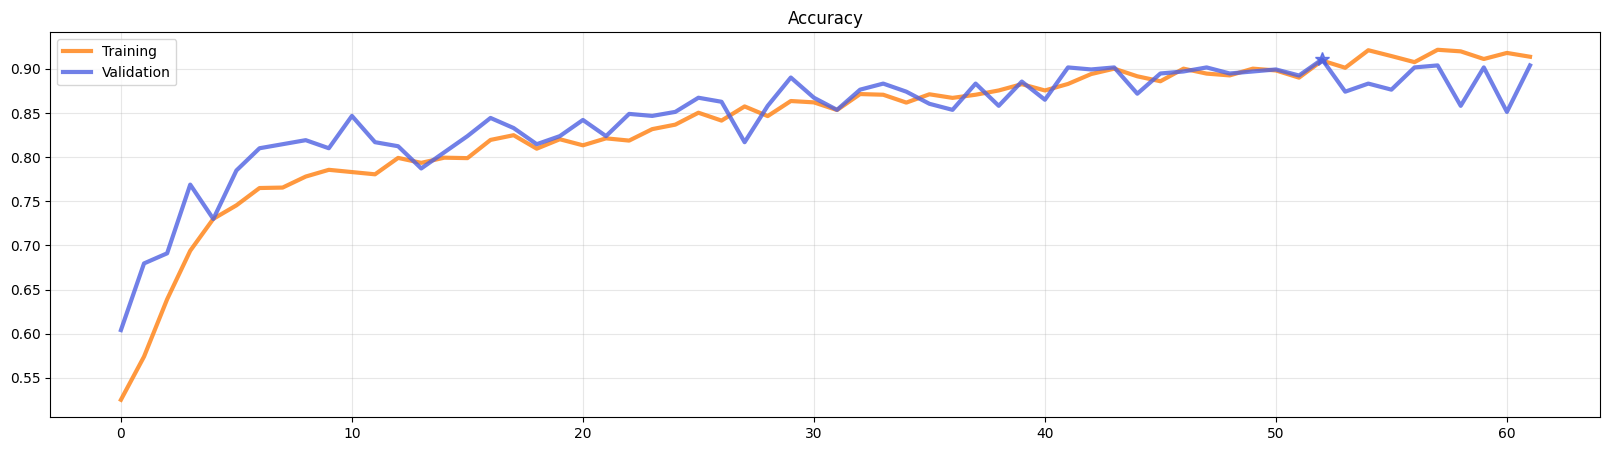

In [ ]:
# Find the epoch with the highest validation accuracy

history=tl_history
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
predictions=tl_model.predict(test_dataset)
y_pred=np.argmax(predictions, axis=1)
out = tf.convert_to_tensor(y_pred)
y_true=test_dataset.labels


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

16/16 [==============================] - 3s 149ms/step
Confusion Matrix:
[[288  18]
 [ 28 151]]
Accuracy: 0.9051546391752577
Precision: 0.893491124260355
F1 Score: 0.867816091954023
Recall: 0.8435754189944135


In [ ]:
tl_model.save('/kaggle/working/VGG19')

In [ ]:
DEFROST=32
tl_model.get_layer('resnet50').trainable = True
for i, layer in enumerate(tl_model.get_layer('resnet50').layers[:-DEFROST]):
    layer.trainable = False

# make sure BatchNorm layers are frozen
for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
    if isinstance(layer, tfkl.BatchNormalization):
        layer.trainable = False

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_ds_mu,
    batch_size = 32,
    epochs = 200,
    validation_data = val_ds,
    class_weight=class_weights,
   callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True), lr_callback]
                # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy' ,factor=20**-4 ,patience=5)]
).history

Epoch 1/200
123/123 [==============================] - 5s 37ms/step - loss: 0.4481 - accuracy: 0.8075 - val_loss: 0.3862 - val_accuracy: 0.8375 - lr: 1.0000e-05
Epoch 2/200
123/123 [==============================] - 4s 34ms/step - loss: 0.4449 - accuracy: 0.8154 - val_loss: 0.3871 - val_accuracy: 0.8352 - lr: 9.9999e-06
Epoch 3/200
123/123 [==============================] - 5s 36ms/step - loss: 0.4447 - accuracy: 0.8198 - val_loss: 0.3836 - val_accuracy: 0.8398 - lr: 9.9998e-06
Epoch 4/200
123/123 [==============================] - 5s 37ms/step - loss: 0.4549 - accuracy: 0.7976 - val_loss: 0.3830 - val_accuracy: 0.8398 - lr: 9.9997e-06
Epoch 5/200
123/123 [==============================] - 5s 36ms/step - loss: 0.4470 - accuracy: 0.8157 - val_loss: 0.3820 - val_accuracy: 0.8444 - lr: 9.9996e-06
Epoch 6/200
123/123 [==============================] - 4s 35ms/step - loss: 0.4404 - accuracy: 0.8172 - val_loss: 0.3862 - val_accuracy: 0.8261 - lr: 9.9995e-06
Epoch 7/200
123/123 [=============

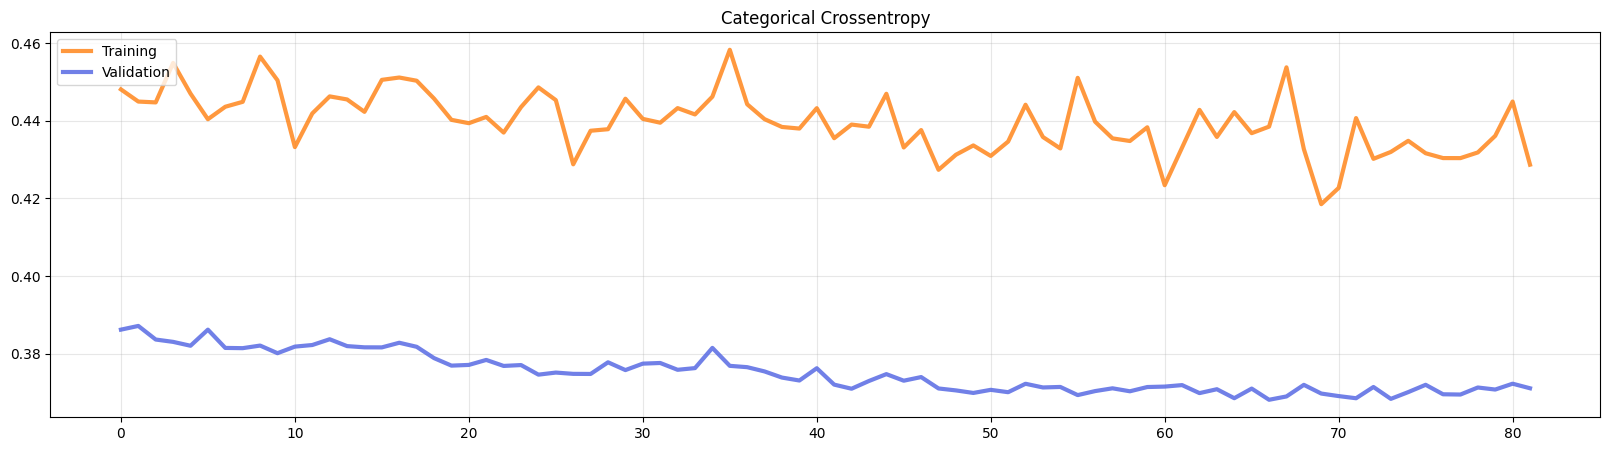

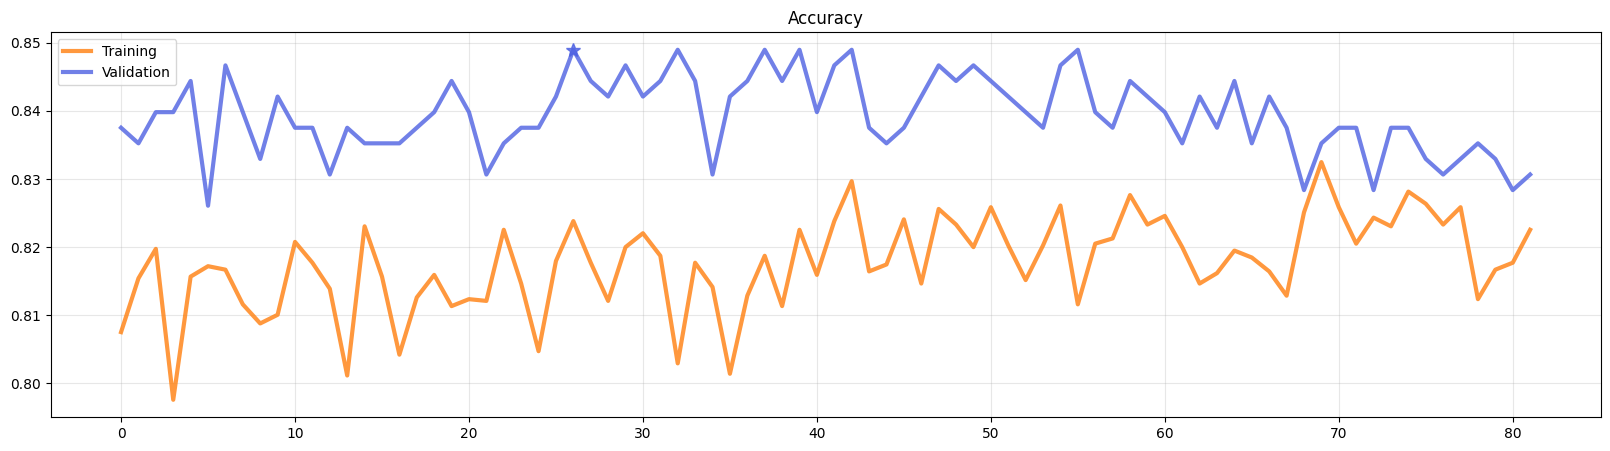

In [ ]:
# Find the epoch with the highest validation accuracy

history=tl_history
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
DEFROST=96
tl_model.get_layer('resnet50').trainable = True
for i, layer in enumerate(tl_model.get_layer('resnet50').layers[:-DEFROST]):
    layer.trainable = False

# make sure BatchNorm layers are frozen
for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
    if isinstance(layer, tfkl.BatchNormalization):
        layer.trainable = False

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_ds_mu,
    batch_size = 32,
    epochs = 200,
    validation_data = val_ds,
    class_weight=class_weights,
   callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True), lr_callback]
                # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy' ,factor=20**-4 ,patience=5)]
).history

Epoch 1/200
123/123 [==============================] - 5s 37ms/step - loss: 0.4392 - accuracy: 0.8106 - val_loss: 0.3687 - val_accuracy: 0.8398 - lr: 1.0000e-05
Epoch 2/200
123/123 [==============================] - 5s 36ms/step - loss: 0.4242 - accuracy: 0.8231 - val_loss: 0.3666 - val_accuracy: 0.8421 - lr: 9.9999e-06
Epoch 3/200
123/123 [==============================] - 5s 35ms/step - loss: 0.4342 - accuracy: 0.8297 - val_loss: 0.3722 - val_accuracy: 0.8284 - lr: 9.9998e-06
Epoch 4/200
123/123 [==============================] - 5s 35ms/step - loss: 0.4384 - accuracy: 0.8205 - val_loss: 0.3696 - val_accuracy: 0.8330 - lr: 9.9997e-06
Epoch 5/200
123/123 [==============================] - 5s 35ms/step - loss: 0.4288 - accuracy: 0.8218 - val_loss: 0.3697 - val_accuracy: 0.8352 - lr: 9.9996e-06
Epoch 6/200
123/123 [==============================] - 5s 36ms/step - loss: 0.4355 - accuracy: 0.8175 - val_loss: 0.3668 - val_accuracy: 0.8398 - lr: 9.9995e-06
Epoch 7/200
123/123 [=============

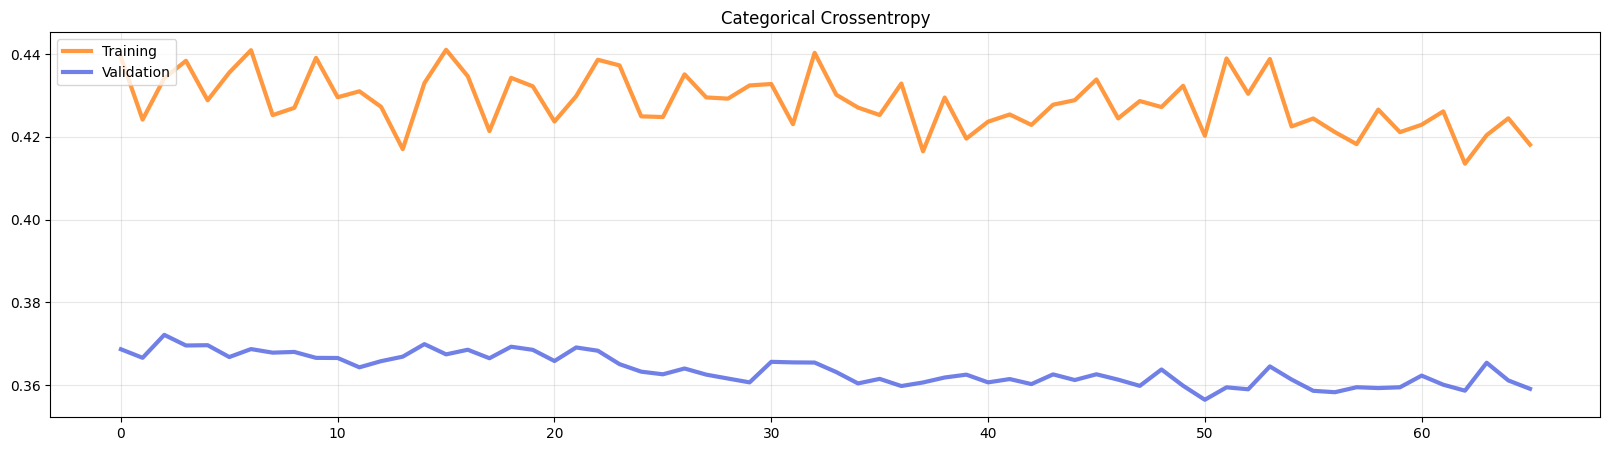

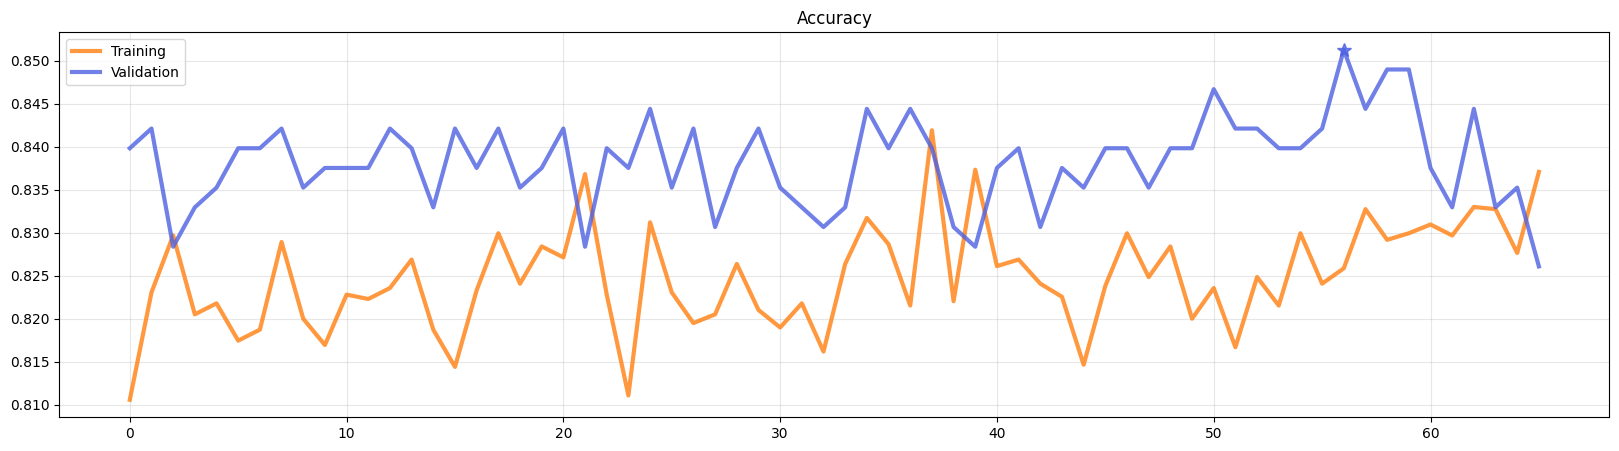

In [ ]:
# Find the epoch with the highest validation accuracy

history=tl_history
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

## **MobilenetV2**

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
MobileNetV2  = tfk.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)
MobileNetV2.trainable = True

regularizer = tfk.regularizers.l2(0.1)

for layer in MobileNetV2.layers:
    if isinstance(layer, tfkl.Conv2D):
        layer.kernel_regularizer = regularizer

scheduler = tfk.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,  # Initial learning rate for training
    decay_steps=10000,            # Number of steps before decaying the learning rate
    decay_rate=0.9,              # Rate at which the learning rate decreases
)

lr_callback = tfk.callbacks.LearningRateScheduler(scheduler)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
preprocessing = tf.keras.Sequential([
       # tfkl.RandomBrightness(0.2,value_range=(0,1)),
          tfkl.RandomFlip("horizontal"),
        tfkl.RandomFlip("vertical"),
       # tfkl.RandomContrast(0.3),
        tfkl.RandomRotation(0.5),
       # tfkl.RandomTranslation(0.2,0.2,fill_mode="reflect"),
        #tfkl.RandomZoom(0.5,0.5,fill_mode="reflect")
    ], name='preprocessing')


inputs = tfk.Input(shape=(96, 96, 3))

preprocess=preprocessing(inputs)
x = preprocess_input(preprocess)

x = MobileNetV2(x)
# Add a Dense layer with 2 units and softmax activation as the classifier


x=tfkl.GlobalAveragePooling2D()(x)
x=tfkl.Dense(128, activation='relu' ,kernel_initializer=tfk.initializers.GlorotNormal())(x)

x=tfkl.Dropout(0.4)(x)


outputs = tfkl.Dense(2, activation='softmax' ,kernel_initializer=tfk.initializers.GlorotNormal() )(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='mobile')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "mobile"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 96, 96, 3)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 96, 96, 3)         0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                            

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_ds_mu,
    batch_size = 32,
    epochs = 200,
    validation_data = val_ds,
    class_weight=class_weights,
   callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True), lr_callback]
                # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy' ,factor=20**-4 ,patience=5)]
).history

Epoch 1/200
123/123 [==============================] - 39s 67ms/step - loss: 0.8274 - accuracy: 0.5540 - val_loss: 0.7339 - val_accuracy: 0.5904 - lr: 1.0000e-05
Epoch 2/200
123/123 [==============================] - 6s 46ms/step - loss: 0.7590 - accuracy: 0.5835 - val_loss: 0.6732 - val_accuracy: 0.6224 - lr: 9.9999e-06
Epoch 3/200
123/123 [==============================] - 6s 45ms/step - loss: 0.6955 - accuracy: 0.6240 - val_loss: 0.6284 - val_accuracy: 0.6384 - lr: 9.9998e-06
Epoch 4/200
123/123 [==============================] - 6s 47ms/step - loss: 0.6596 - accuracy: 0.6637 - val_loss: 0.5944 - val_accuracy: 0.6682 - lr: 9.9997e-06
Epoch 5/200
123/123 [==============================] - 6s 46ms/step - loss: 0.6531 - accuracy: 0.6703 - val_loss: 0.5640 - val_accuracy: 0.7162 - lr: 9.9996e-06
Epoch 6/200
123/123 [==============================] - 6s 46ms/step - loss: 0.6175 - accuracy: 0.6902 - val_loss: 0.5412 - val_accuracy: 0.7185 - lr: 9.9995e-06
Epoch 7/200
123/123 [============

In [ ]:
# Find the epoch with the highest validation accuracy

history=tl_history
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
MobileNetV2  = tfk.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)
MobileNetV2.trainable = True

In [ ]:
preprocessing = tf.keras.Sequential([
       # tfkl.RandomBrightness(0.2,value_range=(0,1)),
          tfkl.RandomFlip("horizontal"),
        tfkl.RandomFlip("vertical"),
       # tfkl.RandomContrast(0.3),
        tfkl.RandomRotation(0.5),
       # tfkl.RandomTranslation(0.2,0.2,fill_mode="reflect"),
        #tfkl.RandomZoom(0.5,0.5,fill_mode="reflect")
    ], name='preprocessing')


inputs = tfk.Input(shape=(96, 96, 3))

preprocess=preprocessing(inputs)
x = preprocess_input(preprocess)

x = MobileNetV2(x)
# Add a Dense layer with 2 units and softmax activation as the classifier

x=tfkl.BatchNormalization()(x)

x=tfkl.GlobalAveragePooling2D()(x)
drop=tfkl.Dropout(0.4)(x)


outputs = tfkl.Dense(2, activation='softmax' ,kernel_initializer=tfk.initializers.GlorotNormal() )(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='mobilenetv2')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

# Display model summary
tl_model.summary()

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_ds_mu,
    batch_size = 32,
    epochs = 50,
    validation_data = val_ds,
    class_weight=class_weights,
   callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
                # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy' ,factor=20**-4 ,patience=5)]
).history

In [ ]:
# Find the epoch with the highest validation accuracy

history=tl_history
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
tl_model.save('mobilenetv2_01_no_finetuning_mixup')

## **VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
VGG16  = tfk.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)
VGG16.trainable = True

In [ ]:
preprocessing = tf.keras.Sequential([
       # tfkl.RandomBrightness(0.2,value_range=(0,1)),
          tfkl.RandomFlip("horizontal"),
        tfkl.RandomFlip("vertical"),
       # tfkl.RandomContrast(0.3),
        tfkl.RandomRotation(0.5),
       # tfkl.RandomTranslation(0.2,0.2,fill_mode="reflect"),
        #tfkl.RandomZoom(0.5,0.5,fill_mode="reflect")
    ], name='preprocessing')


inputs = tfk.Input(shape=(96, 96, 3))

preprocess=preprocessing(inputs)
x = preprocess_input(preprocess)

x = VGG16(x)
# Add a Dense layer with 2 units and softmax activation as the classifier

x=tfkl.BatchNormalization()(x)

x=tfkl.GlobalAveragePooling2D()(x)
drop=tfkl.Dropout(0.4)(x)


outputs = tfkl.Dense(2, activation='softmax' ,kernel_initializer=tfk.initializers.GlorotNormal() )(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='vgg16')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

# Display model summary
tl_model.summary()

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_ds_mu,
    batch_size = 32,
    epochs = 50,
    validation_data = val_ds,
    class_weight=class_weights,
   callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
                # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy' ,factor=20**-4 ,patience=5)]
).history

In [ ]:
# Find the epoch with the highest validation accuracy

history=tl_history
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
tl_model.save('VGG16_01_no_finetuning_mixup')

## **Construct the ensembles**

In [ ]:
ResNet50 = tfk.models.load_model('/kaggle/working/resnet50_01_no_finetuning_mixup')
MobileNetV2 = tfk.models.load_model('/kaggle/working/mobilenetv2_01_no_finetuning_mixup')
VGG16 = tfk.models.load_model('/kaggle/working/VGG16_01_no_finetuning_mixup')

In [ ]:
# Start with full ensemble

models = [ResNet50, MobileNetV2, VGG16]
inputs = tfk.Input(shape=(96,96,3))
outputs = [model(inputs) for model in models]
outputs_ensemble = tfkl.Average()(outputs)
model_ensemble = tfk.Model(inputs=inputs, outputs=outputs_ensemble, name='ensemble_mobilenetv2-vgg16-resnet50')
model_ensemble.save('ensemble_mobilenetv2-vgg16-resnet50')

In [ ]:
predictions=model_ensemble.predict(test_dataset)
y_pred=np.argmax(predictions, axis=1)
out = tf.convert_to_tensor(y_pred)
y_true=test_dataset.labels


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
def TTA(model,TEST_DIR):


        test_datagen = ImageDataGenerator(
                    rotation_range=0.5,
                   # width_shift_range=0.2,
                   # height_shift_range=0.2,
                    #zoom_range=[0.5,1.2],

                    #shear_range=0.2,
                    vertical_flip=True,
                    horizontal_flip=True,
                    fill_mode='reflect')

        y_hats=[]

        n_steps=5
        BATCH=32

        for i in range(n_steps):
            preds=model.predict_generator(test_datagen.flow_from_directory(directory=TEST_DIR,
                                                              target_size=IMG_SHAPE,
                                                             # color_mode='rgb',
                                                              classes=None,
                                                              class_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              seed=seed,
                                                              ))
            y_hats.append(preds)

        y_hats=np.array(y_hats)
        pred=np.mean(y_hats,axis=0)
        results=np.argmax(pred,axis=1)
        #results = results.flatten()
        return results


In [ ]:
results=TTA(model_ensemble,TEST_DIR)
y_pred=results
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

Not too bad, many FP

In [ ]:
# Now ensemble of VGG16 and ResNet50

models = [ResNet50, VGG16]
inputs = tfk.Input(shape=(96,96,3))
outputs = [model(inputs) for model in models]
outputs_ensemble = tfkl.Average()(outputs)
model_ensemble = tfk.Model(inputs=inputs, outputs=outputs_ensemble, name='ensemble_vgg16-resnet50')
model_ensemble.save('ensemble_vgg16-resnet50')

In [ ]:
predictions=model_ensemble.predict(test_dataset)
y_pred=np.argmax(predictions, axis=1)
out = tf.convert_to_tensor(y_pred)
y_true=test_dataset.labels


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
results=TTA(model_ensemble,TEST_DIR)
y_pred=results
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
# Now MobileNetV2 and ResNet50

models = [ResNet50, MobileNetV2]
inputs = tfk.Input(shape=(96,96,3))
outputs = [model(inputs) for model in models]
outputs_ensemble = tfkl.Average()(outputs)
model_ensemble = tfk.Model(inputs=inputs, outputs=outputs_ensemble, name='ensemble_mobilenetv2-resnet50')
model_ensemble.save('ensemble_mobilenetv2-resnet50')

In [ ]:
predictions=model_ensemble.predict(test_dataset)
y_pred=np.argmax(predictions, axis=1)
out = tf.convert_to_tensor(y_pred)
y_true=test_dataset.labels


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
results=TTA(model_ensemble,TEST_DIR)
y_pred=results
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
# Finally VGG16 and MobileNetV2

models = [MobileNetV2, VGG16]
inputs = tfk.Input(shape=(96,96,3))
outputs = [model(inputs) for model in models]
outputs_ensemble = tfkl.Average()(outputs)
model_ensemble = tfk.Model(inputs=inputs, outputs=outputs_ensemble, name='ensemble_mobilenetv2-vgg16')
model_ensemble.save('ensemble_vgg16-mobilenetv2')

In [ ]:
predictions=model_ensemble.predict(test_dataset)
y_pred=np.argmax(predictions, axis=1)
out = tf.convert_to_tensor(y_pred)
y_true=test_dataset.labels


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
results=TTA(model_ensemble,TEST_DIR)
y_pred=results
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

Definetely worst choice

## **EfficientNetB5**

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
EfficientNetB5  = tfk.applications.EfficientNetB5(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
)
EfficientNetB5.trainable = True

In [ ]:
preprocessing = tf.keras.Sequential([
       # tfkl.RandomBrightness(0.2,value_range=(0,1)),
          tfkl.RandomFlip("horizontal"),
        tfkl.RandomFlip("vertical"),
       # tfkl.RandomContrast(0.3),
        tfkl.RandomRotation(0.5),
       # tfkl.RandomTranslation(0.2,0.2,fill_mode="reflect"),
        #tfkl.RandomZoom(0.5,0.5,fill_mode="reflect")
    ], name='preprocessing')

inputs = tfk.Input(shape=(96, 96, 3))

preprocess=preprocessing(inputs)
x = preprocess_input(preprocess)

x = EfficientNetB5(x)
# Add a Dense layer with 2 units and softmax activation as the classifier

x=tfkl.BatchNormalization()(x)

x=tfkl.GlobalAveragePooling2D()(x)
drop=tfkl.Dropout(0.4)(x)


outputs = tfkl.Dense(2, activation='softmax' ,kernel_initializer=tfk.initializers.GlorotNormal() )(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='efficientnetb5')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

# Display model summary
tl_model.summary()

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_ds_mu,
    batch_size = 32,
    epochs = 50,
    validation_data = val_ds,
    class_weight=class_weights,
   callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
                # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy' ,factor=20**-4 ,patience=5)]
).history

In [ ]:
# Find the epoch with the highest validation accuracy

history=tl_history
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
tl_model.save('efficientnetb5_01_no_finetuning_mixup')

In [ ]:
predictions=tl_model.predict(test_dataset)
y_pred=np.argmax(predictions, axis=1)
out = tf.convert_to_tensor(y_pred)
y_true=test_dataset.labels


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
results=TTA(model_ensemble,TEST_DIR)
y_pred=results
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
EfficientNetB5 = tfk.models.load_model('/kaggle/working/efficientnetb5_01_no_finetuning_mixup')

In [ ]:
# Construct ResNet50 and EfficientNetB5 ensemble

models = [ResNet50, EfficientNetB5]
inputs = tfk.Input(shape=(96,96,3))
outputs = [model(inputs) for model in models]
outputs_ensemble = tfkl.Average()(outputs)
model_ensemble = tfk.Model(inputs=inputs, outputs=outputs_ensemble, name='ensemble_efficientnetb5-resnet50')
model_ensemble.save('ensemble_efficientnetb5-resnet50')

In [ ]:
predictions=model_ensemble.predict(test_dataset)
y_pred=np.argmax(predictions, axis=1)
out = tf.convert_to_tensor(y_pred)
y_true=test_dataset.labels


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
results=TTA(model_ensemble,TEST_DIR)
y_pred=results
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
# Construct ResNet50, EfficientNetB5 and MobileNetV2 ensemble

models = [ResNet50, EfficientNetB5, MobileNetV2]
inputs = tfk.Input(shape=(96,96,3))
outputs = [model(inputs) for model in models]
outputs_ensemble = tfkl.Average()(outputs)
model_ensemble = tfk.Model(inputs=inputs, outputs=outputs_ensemble, name='ensemble_mobilenetv2-efficientnetb5-resnet50')
model_ensemble.save('ensemble_mobilenetv2-efficientnetb5-resnet50')

In [ ]:
predictions=model_ensemble.predict(test_dataset)
y_pred=np.argmax(predictions, axis=1)
out = tf.convert_to_tensor(y_pred)
y_true=test_dataset.labels


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
results=TTA(model_ensemble,TEST_DIR)
y_pred=results
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

## **Weight the models**

In [ ]:
class WeightedAverageLayer(tfkl.Layer):
    def __init__(self, w1, w2, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1]

In [ ]:
# Construct ResNet50 and EfficientNetB5 ensemble

models = [ResNet50, EfficientNetB5]
inputs = tfk.Input(shape=(96,96,3))
outputs = [model(inputs) for model in models]
ensemble_output = WeightedAverageLayer(0.4, 0.6)(outputs)
model_ensemble = tfk.Model(inputs=inputs, outputs=ensemble_output, name='ensemble_06efficientnetb5-04resnet50')
model_ensemble.save('ensemble_06efficientnetb5-04resnet50')

In [ ]:
predictions=model_ensemble.predict(test_dataset)
y_pred=np.argmax(predictions, axis=1)
out = tf.convert_to_tensor(y_pred)
y_true=test_dataset.labels


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

## **Hyperparameters Tuning of the ensemble**

In [ ]:
model_ensemble.summary()

## **Miscellaneous**

In [ ]:
DEFROST=5
tl_model = tfk.models.load_model('/kaggle/working/resnet50_01_no_finetuning_mixup')

In [ ]:
tl_model.get_layer('resnet50').trainable = True
for i, layer in enumerate(tl_model.get_layer('resnet50').layers[:-DEFROST]):
    layer.trainable = False

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Display model summary
tl_model.summary()

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_ds_mu,
    batch_size = 32,
    epochs = 30,
    validation_data = val_ds,
    class_weight=class_weights,
   callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
                # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy' ,factor=20**-4 ,patience=5)]
).history

In [ ]:
# Find the epoch with the highest validation accuracy

history=tl_history
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
tl_model.save('resnet50_01_first_finetuning_mixup')

In [ ]:
DEFROST=10
FROST=5
tl_model = tfk.models.load_model('/kaggle/working/resnet50_01_first_finetuning_mixup')

In [ ]:
tl_model.get_layer('resnet50').trainable = True
for i, layer in enumerate(tl_model.get_layer('resnet50').layers[:-DEFROST]):
    layer.trainable = False


for i, layer in enumerate(tl_model.get_layer('resnet50').layers[-FROST:]):
    layer.trainable = True


# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Display model summary
tl_model.summary()

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_ds_mu,
    batch_size = 32,
    epochs = 30,
    validation_data = val_ds,
    class_weight=class_weights,
   callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
                # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy' ,factor=20**-4 ,patience=5)]
).history

In [ ]:
tl_model.save('resnet50_01_second_finetuning_mixup')

In [ ]:
DEFROST=5

tl_model = tfk.models.load_model('/kaggle/working/resnet50_01_second_finetuning_mixup')

In [ ]:
tl_model.get_layer('resnet50').trainable = True
for i, layer in enumerate(tl_model.get_layer('resnet50').layers[:-DEFROST]):
    layer.trainable = False

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Display model summary
tl_model.summary()

In [ ]:
# Train the model
tl_history = tl_model.fit(
    train_ds_mu,
    batch_size = 32,
    epochs = 30,
    validation_data = val_ds,
    class_weight=class_weights,
   callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)]
                # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy' ,factor=20**-4 ,patience=5)]
).history

In [ ]:
tl_model.save('resnet50_01_third_finetuning_mixup')

In [ ]:
predictions=tl_model.predict(test_dataset)

In [ ]:
y_pred=np.argmax(predictions, axis=1)

In [ ]:
y_pred

In [ ]:
out = tf.convert_to_tensor(y_pred)
out

In [ ]:
y_true=test_dataset.labels

In [ ]:

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

In [ ]:
def TTA(model,TEST_DIR):


        test_datagen = ImageDataGenerator(
                    rotation_range=0.5,
                   # width_shift_range=0.2,
                   # height_shift_range=0.2,
                    #zoom_range=[0.5,1.2],

                    #shear_range=0.2,
                    vertical_flip=True,
                    horizontal_flip=True,
                    fill_mode='reflect')

        y_hats=[]

        n_steps=5
        BATCH=32

        for i in range(n_steps):
            preds=model.predict_generator(test_datagen.flow_from_directory(directory=TEST_DIR,
                                                              target_size=IMG_SHAPE,
                                                             # color_mode='rgb',
                                                              classes=None,
                                                              class_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              seed=seed,
                                                              ))
            y_hats.append(preds)

        y_hats=np.array(y_hats)
        pred=np.mean(y_hats,axis=0)
        results=np.argmax(pred,axis=1)
        #results = results.flatten()
        return results





In [ ]:
results=TTA(tl_model,TEST_DIR)
y_pred=results
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)